### Exemplo 6 - DIAGNÓSTICO DE MULTICOLINEARIDADE EM MODELOS DE REGRESSÃO

In [1]:
# Importação dos pacotes
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.io as pio
pio.renderers.default = 'notebook'

from scipy.stats import pearsonr # correlações de Pearson
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos

import pingouin as pg # outro modo para obtenção de matrizes de correlações
import warnings

from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox

import networkx as nx
import matplotlib.cm as cm

from statsmodels.stats.outliers_influence import variance_inflation_factor

O que é multicolinearidade?
- corr[$X_qi$, $X_pi$] $\not=$ 0


### **Multicolinearidade em Regressão Múltipla**

#### **Definição**
Multicolinearidade ocorre quando duas ou mais variáveis preditoras em um modelo de regressão múltipla estão altamente correlacionadas. Isso significa que elas carregam informações redundantes ou semelhantes sobre a variabilidade da variável resposta, o que pode dificultar a distinção dos efeitos individuais dessas variáveis preditoras no modelo.

#### **Impactos da Multicolinearidade no Modelo**
1. **Coeficientes Instáveis**: Quando a multicolinearidade está presente, os coeficientes de regressão das variáveis preditoras se tornam instáveis e podem mudar significativamente com pequenas alterações nos dados. Isso torna difícil interpretar os coeficientes, pois o impacto de uma variável preditora na variável resposta pode parecer maior ou menor do que realmente é.

2. **Aumento da Variância dos Coeficientes**: A multicolinearidade leva a um aumento na variância dos estimadores dos coeficientes. Como resultado, os intervalos de confiança para os coeficientes se tornam mais amplos, diminuindo a precisão das estimativas.

3. **Dificuldade em Identificar Variáveis Significativas**: Devido à alta correlação entre as variáveis preditoras, o modelo pode indicar que algumas dessas variáveis não são estatisticamente significativas, quando na verdade elas podem ser. Isso ocorre porque a multicolinearidade inflaciona os erros padrão dos coeficientes.

4. **Confusão na Interpretação dos Resultados**: Em casos de multicolinearidade severa, pode ser difícil determinar o efeito real de cada variável preditora na variável resposta, já que as variáveis preditoras influenciam fortemente umas às outras.

#### **Como Lidar com a Multicolinearidade**

1. **Remover Variáveis Preditivas Correlacionadas**: Uma abordagem direta é remover uma ou mais das variáveis preditoras que estão altamente correlacionadas. Isso pode ser feito após uma análise de correlação entre as variáveis preditoras.

2. **Combinação de Variáveis (Transformações)**: Outra estratégia é combinar as variáveis preditoras correlacionadas em uma única variável. Isso pode ser feito por meio de somas, médias ou até técnicas mais avançadas como Análise de Componentes Principais (PCA).

3. **Regularização (Ridge e Lasso Regression)**: Métodos de regularização, como a regressão Ridge ou Lasso, introduzem uma penalidade na magnitude dos coeficientes, o que pode ajudar a reduzir os efeitos da multicolinearidade. A regressão Ridge tende a reduzir os coeficientes das variáveis correlacionadas, enquanto a Lasso pode até mesmo eliminar algumas delas do modelo.

4. **Aumentar o Tamanho da Amostra**: Se possível, aumentar o tamanho da amostra pode ajudar a mitigar os efeitos da multicolinearidade, pois com mais dados, o modelo pode distinguir melhor entre as variáveis preditoras correlacionadas.

5. **Análise de Fatores de Inflação da Variância (VIF)**: O VIF é uma medida que quantifica a gravidade da multicolinearidade. Valores de VIF acima de 10 indicam alta multicolinearidade, e as variáveis com altos valores de VIF podem ser removidas ou combinadas.

In [2]:
df_salarios = pd.read_csv('/home/usp_ds_analytics/regression_analysis/data/salarios.csv', delimiter=',')
df_salarios.head()

,nome,salario,rh1,econometria1,rh2,econometria2
0,Patricia,2525.340820,3.0,9.0,9.0,4.50
1,Luiz,2498.574951,7.0,8.0,8.0,4.00
2,Dalila,2364.686768,10.0,9.5,9.5,4.75
3,Leonor,1981.349854,10.0,7.0,7.0,3.50
4,Ovidio,1892.807983,7.0,6.0,6.0,3.10


In [3]:
# Características das variáveis do dataset
df_salarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   nome          15 non-null     object 
 1   salario       15 non-null     float64
 2   rh1           15 non-null     float64
 3   econometria1  15 non-null     float64
 4   rh2           15 non-null     float64
 5   econometria2  15 non-null     float64
dtypes: float64(5), object(1)
memory usage: 852.0+ bytes


In [4]:
# Estatísticas univariadas
df_salarios.describe()

,salario,rh1,econometria1,rh2,econometria2
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,2032.150578,7.180000,6.400000,6.400000,3.240000
std,312.507361,3.169317,2.221647,2.221647,1.061367
min,1505.627563,1.400000,3.000000,3.000000,1.500000
25%,1870.515320,4.450000,4.500000,4.500000,2.250000
50%,2001.654297,8.000000,7.000000,7.000000,3.500000
75%,2219.607788,9.950000,8.000000,8.000000,4.000000
max,2525.340820,10.000000,9.500000,9.500000,4.750000


### Matriz de correlação

In [5]:
correlation_matrix = df_salarios.iloc[:,1:6].corr()
correlation_matrix

,salario,rh1,econometria1,rh2,econometria2
salario,1.000000,-0.273192,0.909022,0.909022,0.897694
rh1,-0.273192,1.000000,-0.265076,-0.265076,-0.269104
econometria1,0.909022,-0.265076,1.000000,1.000000,0.993888
rh2,0.909022,-0.265076,1.000000,1.000000,0.993888
econometria2,0.897694,-0.269104,0.993888,0.993888,1.000000


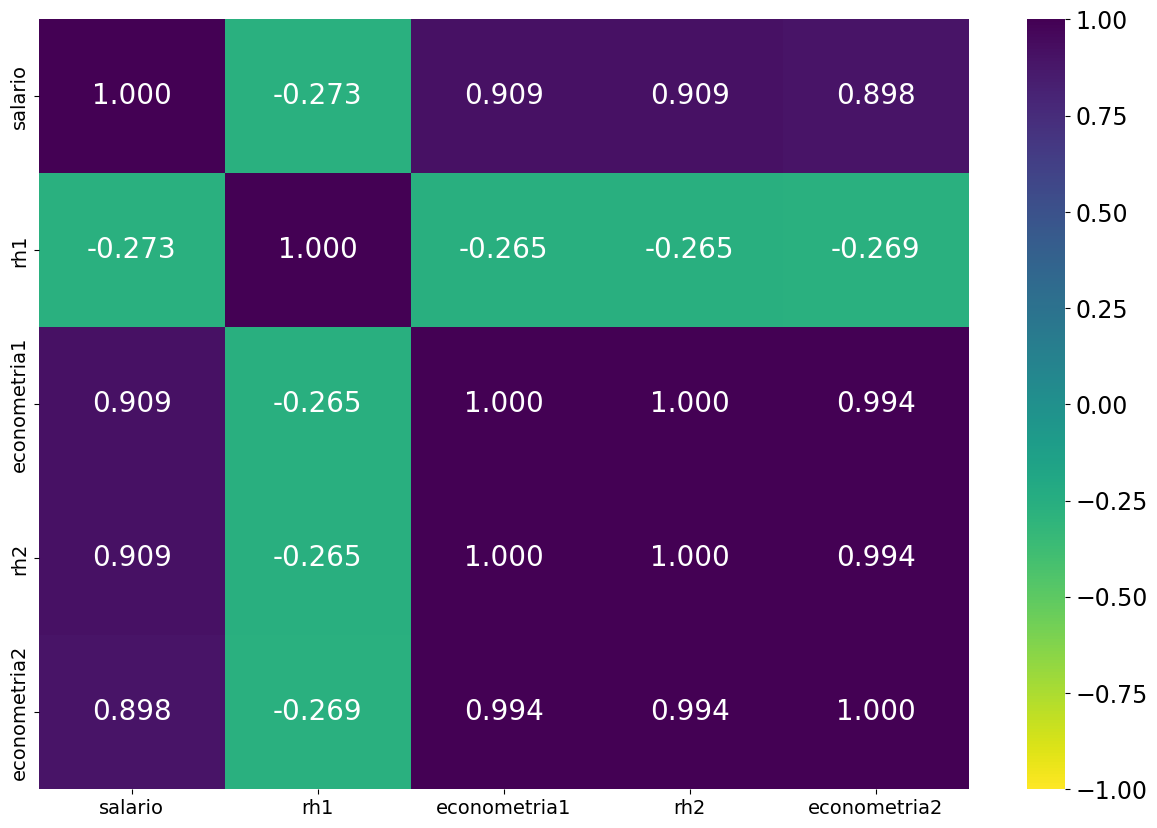

In [6]:
# Mapa de calor com as correlações entre todas as variáveis quantitativas
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".3f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 20}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

Vamos pensar em 2 cenários:
- salário e rh1 + econometria1
- salário e rh2 + econometria2

- CORRELAÇÃO BAIXA (variáveis 'rh1' e 'econometria1')
- CORRELAÇÃO MUITO ALTA (variáveis 'rh2' e 'econometria2')

In [7]:
# Correlação entre 'rh1' e 'econometria1', com p-value
corr1, p_value1 = pearsonr(df_salarios['rh1'], df_salarios['econometria1'])
"{:.4f}".format(corr1), "{:.4f}".format(p_value1)

# Matriz de correlação (maneira simples) pela função 'corr'
corr1 = df_salarios[['rh1','econometria1']].corr()
corr1

,rh1,econometria1
rh1,1.000000,-0.265076
econometria1,-0.265076,1.000000


In [8]:
# Maneira mais elaborada pela função 'rcorr' do pacote 'pingouin'
warnings.filterwarnings("ignore", category=FutureWarning)

corr1b = pg.rcorr(df_salarios[['rh1','econometria1']], method='pearson',
                  upper='pval', decimals=6,
                  pval_stars={0.01: '***',
                              0.05: '**',
                              0.10: '*'})
corr1b

,rh1,econometria1
rh1,-,
econometria1,-0.265076,-


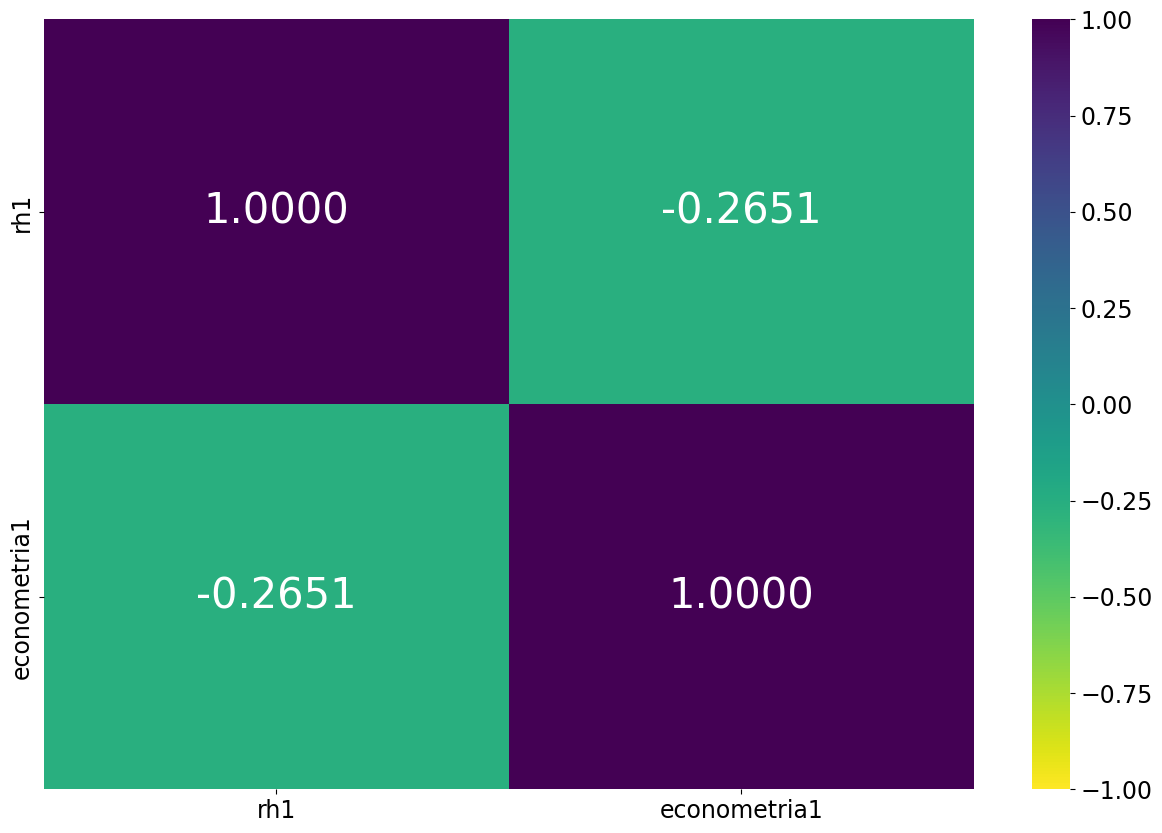

In [9]:
# Mapa de calor com a correlação entre 'rh1' e 'econometria1'
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(corr1, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 30}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

### Grafo com a inter-relação entre as variáveis do dataframe 'df1'

In [10]:
df1 = df_salarios[['salario','rh1','econometria1']]
cormat1 = df1.corr()
cormat1

,salario,rh1,econometria1
salario,1.000000,-0.273192,0.909022
rh1,-0.273192,1.000000,-0.265076
econometria1,0.909022,-0.265076,1.000000


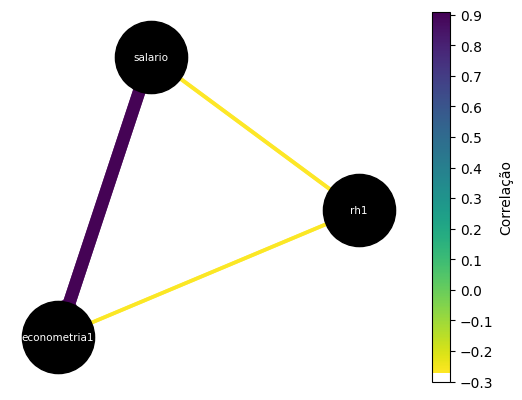

In [11]:
# Criação de um grafo direcionado
G = nx.DiGraph()

# Adição das variáveis como nós do grafo
for variable in cormat1.columns:
    G.add_node(variable)

# Adição das arestas com espessuras proporcionais às correlações
for i, variable1 in enumerate(cormat1.columns):
    for j, variable2 in enumerate(cormat1.columns):
        if i != j:
            correlation = cormat1.iloc[i, j]
            if abs(correlation) > 0:
                G.add_edge(variable1, variable2, weight=correlation)

# Obtenção da lista de correlações das arestas
correlations = [d["weight"] for _, _, d in G.edges(data=True)]

# Definição da dimensão dos nós
node_size = 2700

# Definição da cor dos nós
node_color = 'black'

# Definição da escala de cores das retas (correspondência com as correlações)
cmap = plt.colormaps.get_cmap('viridis_r')

# Criação de uma lista de espessuras das arestas proporcional às correlações
edge_widths = [abs(d["weight"]) * 10 for _, _, d in G.edges(data=True)]

# Criação do layout do grafo com maior distância entre os nós
pos = nx.spring_layout(G, k=0.75)  # k para controlar a distância entre os nós

# Desenho dos nós e das arestas com base nas correlações e espessuras
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations,
                       edge_cmap=cmap, alpha=0.9)

# Adição dos rótulos dos nós
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=7.5, font_color='white')

# Ajuste dos limites dos eixos
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

# Criação da legenda com a escala de cores definida
smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

# Definição dos ticks da colorbar
cbar.set_ticks(np.arange(round(min(correlations),1),
                         max(correlations), 0.1))

# Exibição do gráfico
plt.show()

Parece que não teremos problema em tirar 'rh1', pois não tem correlação com 'salário', e nem com 'econometria1'

### Modelo 1

In [12]:
modelo1 = sm.OLS.from_formula('salario ~ rh1 + econometria1', df_salarios).fit()

modelo1.summary()

/root/.local/share/virtualenvs/usp_ds_analytics-M2oHMey2/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                salario   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     28.77
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           2.64e-05
Time:                        11:19:19   Log-Likelihood:                -93.759
No. Observations:                  15   AIC:                             193.5
Df Residuals:                      12   BIC:                             195.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1246.6172    163.783      7.611      0.000     889.765    1603.469
rh1             -3.4184     12.263     -0.279      0.785     -30.137      23.300
econometria1   126.5746     17.494      7.235      0.000      88.459     164.691
==============================================================================
Omnibus:                        1.817   Durbin-Watson:                   1.536
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.396
Skew:                           0.597   Prob(JB):                        0.498
Kurtosis:                       2.101   Cond. No.                         45.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretação 
- Teste F: Permite analisar se pelo menos um dos $\beta$'s é estatisticamente significante para a explicação do comportamento de Y
- Teste t: Permite analisar se cada um dos parâmetros, individualmente, é estatisticamente diferente de zero (no caso de regressão simples, apresenta a mesma significância da estatística F)

In [13]:
# Vamos confirmar se realmente 'rh1' é forte candidato a sair?
modelo1_aux1 = sm.OLS.from_formula('salario ~ rh1', df_salarios).fit()

modelo1_aux1.summary()

/root/.local/share/virtualenvs/usp_ds_analytics-M2oHMey2/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                salario   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.048
Date:                Tue, 20 Aug 2024   Prob (F-statistic):              0.325
Time:                        11:19:19   Log-Likelihood:                -106.35
No. Observations:                  15   AIC:                             216.7
Df Residuals:                      13   BIC:                             218.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2225.5645    205.346     10.838      0.000    1781.942    2669.187
rh1          -26.9379     26.308     -1.024      0.325     -83.772      29.896
==============================================================================
Omnibus:                        1.302   Durbin-Watson:                   1.341
Prob(Omnibus):                  0.521   Jarque-Bera (JB):                0.795
Skew:                           0.068   Prob(JB):                        0.672
Kurtosis:                       1.880   Cond. No.                         20.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Sim, não vai rolar de manter rh1

### Procedimento Stepwise no 'modelo 1'

In [14]:
from statstests.process import stepwise

modelo1_step = stepwise(modelo1, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 salario ~ Q('rh1') + Q('econometria1')

 Discarding atribute "Q('rh1')" with p-value equal to 0.7851743044424093 

Estimating model...: 
 salario ~ Q('econometria1')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('rh1')", 'p-value': np.float64(0.7851743044424093)}

 Model after stepwise process...: 
 salario ~ Q('econometria1') 

                            OLS Regression Results                            
Dep. Variable:                salario   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     61.85
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           2.69e-06
Time:                        11:19:19   Log-Likelihood:                -93.807
No. Observations:                  15   AIC:                             191.6
Df Resi

/root/.local/share/virtualenvs/usp_ds_analytics-M2oHMey2/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.



#### Diagnóstico de multicolinearidade (Variance Inflation Factor e Tolerance)

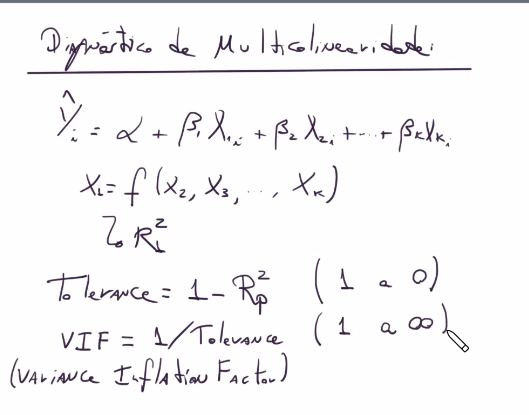

In [15]:
# Calculando os valores de VIF
X1 = sm.add_constant(df_salarios[['rh1', 'econometria1']])
VIF = pd.DataFrame()
VIF["Variável"] = X1.columns[1:]
VIF["VIF"] = [variance_inflation_factor(X1.values, i+1)
              for i in range(X1.shape[1]-1)]

# Calculando as Tolerâncias
VIF["Tolerância"] = 1 / VIF["VIF"]
VIF

,Variável,VIF,Tolerância
0,rh1,1.075576,0.929735
1,econometria1,1.075576,0.929735


No caso acima, como são apenas 2 variáveis, obtiveram o mesmo VIF

- VIF baixo: ausência de multicolinearidade
- VIF alto: existência de multicolinearidade

### Cenário 2: 'rh2' e 'econometria2'
Correlação muito alta

In [16]:
# Correlação entre 'rh2' e 'econometria2', com p-value
corr2, p_value2 = pearsonr(df_salarios['rh2'], df_salarios['econometria2'])
"{:.4f}".format(corr2), "{:.4f}".format(p_value2)

# Matriz de correlação (maneira simples) pela função 'corr'
corr2 = df_salarios[['rh2','econometria2']].corr()
corr2

,rh2,econometria2
rh2,1.000000,0.993888
econometria2,0.993888,1.000000


In [17]:
# Maneira mais elaborada pela função 'rcorr' do pacote 'pingouin'
corr2b = pg.rcorr(df_salarios[['rh2','econometria2']], method='pearson',
                  upper='pval', decimals=6,
                  pval_stars={0.01: '***',
                              0.05: '**',
                              0.10: '*'})
corr2b

,rh2,econometria2
rh2,-,***
econometria2,0.993888,-


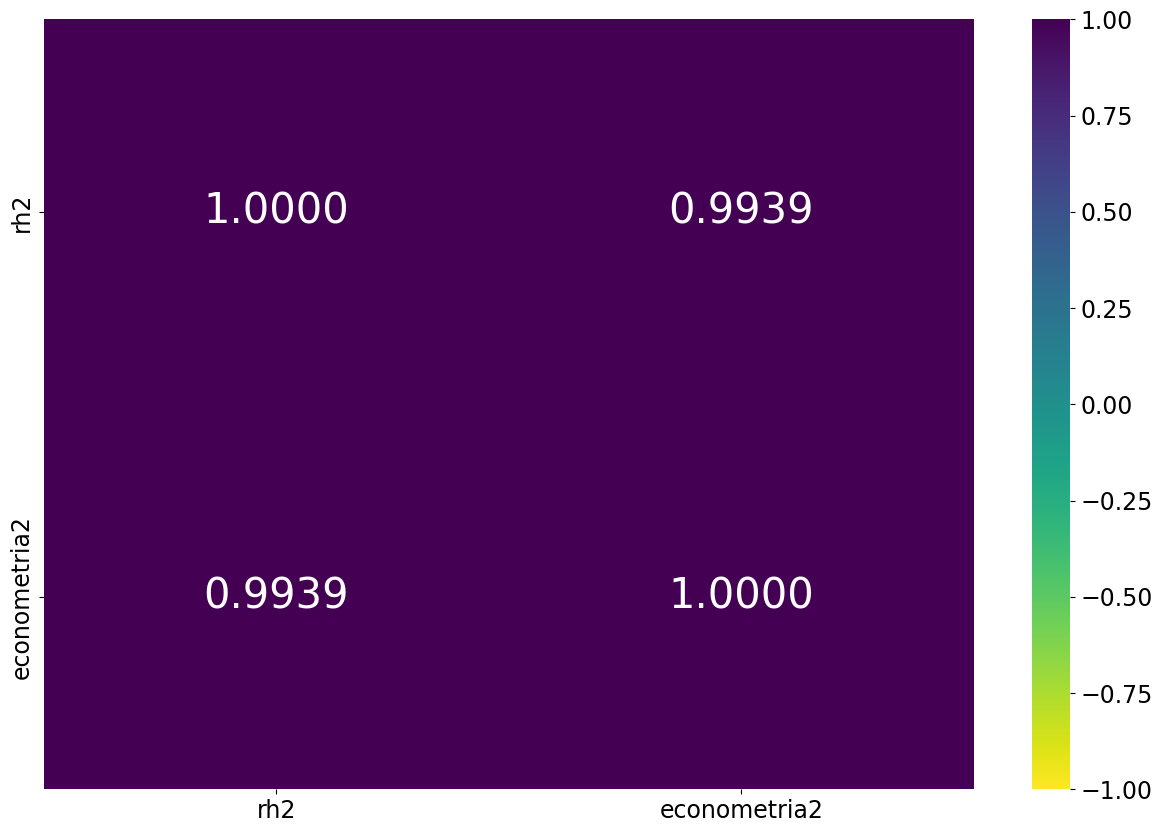

In [18]:
# Mapa de calor com a correlação entre 'rh2' e 'econometria2'
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(corr2, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 30}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

#### Grafo com a inter-relação entre as variáveis do dataframe 'df2'

In [19]:
df2 = df_salarios[['salario','rh2','econometria2']]
cormat2 = df2.corr()
cormat2

,salario,rh2,econometria2
salario,1.000000,0.909022,0.897694
rh2,0.909022,1.000000,0.993888
econometria2,0.897694,0.993888,1.000000


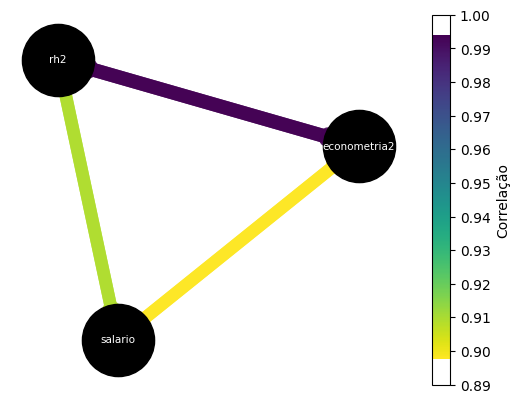

In [20]:
# Criação de um grafo direcionado
G = nx.DiGraph()

# Adição das variáveis como nós do grafo
for variable in cormat2.columns:
    G.add_node(variable)

# Adição das arestas com espessuras proporcionais às correlações
for i, variable1 in enumerate(cormat2.columns):
    for j, variable2 in enumerate(cormat2.columns):
        if i != j:
            correlation = cormat2.iloc[i, j]
            if abs(correlation) > 0:
                G.add_edge(variable1, variable2, weight=correlation)

# Obtenção da lista de correlações das arestas
correlations = [d["weight"] for _, _, d in G.edges(data=True)]

# Definição da dimensão dos nós
node_size = 2700

# Definição da cor dos nós
node_color = 'black'

# Definição da escala de cores das retas (correspondência com as correlações)
cmap = plt.colormaps.get_cmap('viridis_r')

# Criação de uma lista de espessuras das arestas proporcional às correlações
edge_widths = [abs(d["weight"]) * 10 for _, _, d in G.edges(data=True)]

# Criação do layout do grafo com maior distância entre os nós
pos = nx.spring_layout(G, k=0.75)  # k para controlar a distância entre os nós

# Desenho dos nós e das arestas com base nas correlações e espessuras
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations,
                       edge_cmap=cmap, alpha=0.9)

# Adição dos rótulos dos nós
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=7.5, font_color='white')

# Ajuste dos limites dos eixos
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

# Criação da legenda com a escala de cores definida
smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

# Definição dos ticks da colorbar
cbar.set_ticks(np.arange(round(min(correlations) - 0.01,2),
                         max(correlations) + 0.01, 0.01))

# Exibição do gráfico
plt.show()

### Modelo 2

In [21]:
modelo2 = sm.OLS.from_formula('salario ~ rh2 + econometria2', df_salarios).fit()

modelo2.summary()

/root/.local/share/virtualenvs/usp_ds_analytics-M2oHMey2/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                salario   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     29.10
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           2.50e-05
Time:                        11:19:19   Log-Likelihood:                -93.688
No. Observations:                  15   AIC:                             193.4
Df Residuals:                      12   BIC:                             195.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1241.8527    130.172      9.540      0.000     958.233    1525.473
rh2            194.0845    152.087      1.276      0.226    -137.285     525.454
econometria2  -139.4577    318.348     -0.438      0.669    -833.079     554.164
==============================================================================
Omnibus:                        1.720   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.309
Skew:                           0.554   Prob(JB):                        0.520
Kurtosis:                       2.068   Cond. No.                         75.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Prob (F-statistic):	2.50e-05 - pelo menos um pvalue de $\beta$ é estatisticamente significante diferente de 0
- Ops, nenhum dos $\beta$'s mostraram é estatisticamente significante?
    - rh2: 0.226
    - econometria2: 0.669

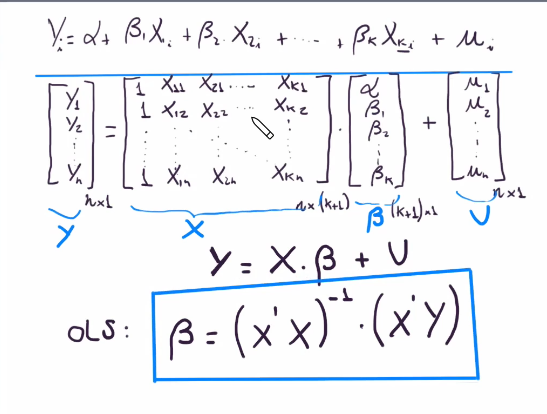

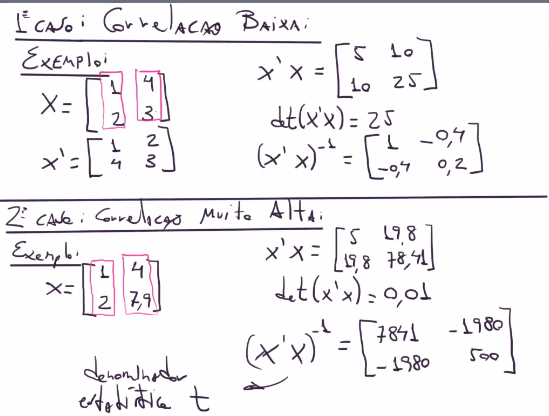

#### Diagnóstico de multicolinearidade (Variance Inflation Factor e Tolerance)

In [22]:
# Calculando os valores de VIF
X2 = sm.add_constant(df_salarios[['rh2', 'econometria2']])
VIF = pd.DataFrame()
VIF["Variável"] = X2.columns[1:]
VIF["VIF"] = [variance_inflation_factor(X2.values, i+1)
              for i in range(X2.shape[1]-1)]

# Calculando as Tolerâncias
VIF["Tolerância"] = 1 / VIF["VIF"]
VIF

,Variável,VIF,Tolerância
0,rh2,82.061458,0.012186
1,econometria2,82.061458,0.012186


VIF muito alto é um diagnóstico. Pode mostrar que aquela variável pode ser tirada, por conta da multicolinearidade.

Temos 1 VIF por variável

Posso usar o modelo mesmo se ele apresentar multicolinearidade? Posso, desde que utilize o procedimento `stepwise`. Prof. Fávaro comentou que a multicolinearidade pode, inclusive, inverter a polaridade dos $\beta$'s. Isso prejudica a capacidade inferencial.

### Modelo 2 aux1, rodando 'rh2' em funçaõ da 'econometria2'

> continuar em 1'34"

In [23]:
modelo2_aux1 = sm.OLS.from_formula('rh2 ~ econometria2', 
                                   df_salarios).fit()

modelo2_aux1.summary()

/root/.local/share/virtualenvs/usp_ds_analytics-M2oHMey2/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rh2   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1054.
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           7.89e-14
Time:                        11:30:26   Log-Likelihood:                0.31565
No. Observations:                  15   AIC:                             3.369
Df Residuals:                      13   BIC:                             4.785
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3405      0.218     -1.563      0.142      -0.811       0.130
econometria2     2.0804      0.064     32.462      0.000       1.942       2.219
==============================================================================
Omnibus:                       29.838   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.376
Skew:                          -2.641   Prob(JB):                     1.40e-10
Kurtosis:                       9.686   Cond. No.                         12.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# Cálculo da tolerância
tolerance2 = 1 - modelo2_aux1.rsquared
tolerance2

np.float64(0.012185988772813183)

In [25]:
# Cálculo do VIF
VIF2 = 1/tolerance2
VIF2

np.float64(82.06145751840752)

O VIF por sí não pode ser usado como marca de corte, mas ele pode ser utilizado para mostrar a hierarquia de importância de variáveis.

Como detectar a multicolinearidade?
- sinais inesperados dos coeficientes
- testes t não significantes e teste F significante

Fontes geradoras de multicolinearidade:
- Existência de variáveis que apresentam a mesma tendência durante alguns períodos, em decorrência da seleção de uma amostra que inclua apenas observações referentes a estes períodos.
- Utilização de amostras com reduzido número de observações.
- Utilização de valores defasados em algumas das variáveis explicativas como “novas” explicativas.

Consequências da multicolinearidade:
- As significâncias estatísticas dos parâmetros  = (X’X)-1X’Y são sensíveis às correlações entre as variáveis explicativas.
- Os elementos da diagonal principal da matriz (X’X)-1 aparecem no denominador da estatística t. Como a presença da multicolinearidade gera valores muito altos na diagonal da referida matriz, como vimos, ocorre a redução no valor da estatística t, sem alteração no cálculo da estatística F.